# Importing the data


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

file_ = "/content/sample_data/IMDB_movies.csv"
df = pd.read_csv(file_, low_memory=False)

In [1]:
# Note: This is a shortcut for using cleaned data so I don't have to rerun the
# cleaning tasks every time I want to run this notebook

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

file_ = "/content/sample_data/IMDB_movies_cleaned.csv"
df = pd.read_csv(file_, low_memory=False)

# Now split into Training and Test data
X = df.iloc[:, 0:-1]
y = df['success']

X_train, X_test, y_train, y_test = train_test_split(
       X, y, test_size=0.3, random_state=1)

# Munging the data

In [ ]:
# Remove all rows that don't have Budget and worlwide_gross_income [sic]
df = df.dropna(subset=['budget','worlwide_gross_income'])

# Remove all rows where the budget isn't in $ (because it would be too time consuming to convert currency)
df = df[pd.DataFrame([df['budget'].str.contains('\$')]).T.any(axis=1)]

# Remove $ and , from those columns
df['budget'] = df['budget'].str.replace('$', '').str.replace(',', '').astype(int)
df['worlwide_gross_income'] = df['worlwide_gross_income'].str.replace('$', '').str.replace(',', '').astype(int)

# Drop all movies whose budget < 10,000 (ex, The Devil's Doorway has a budget of $1)
df.drop(df.index[df['budget'] < 10000], inplace = True)

# Get the month from the date_published field
df['month'] = pd.DatetimeIndex(df['date_published']).month

# Drop columns I don't need 
df.drop(['imdb_title_id', 'title','description','date_published','production_company','usa_gross_income','language','country','year'], axis=1, inplace=True)

# Useful to see but not needed in the model
df.drop(['original_title'], axis=1, inplace=True)

# Now since there are only a handful of rows with NAN left, we can drop them
df = df.dropna(axis=0)

# What is a success?  Any move that grossed > 2.5x its budget
df['success'] = np.where(df['worlwide_gross_income'] > 2.5 * df['budget'], 1, 0)

# Drop variables subject to hindsight bias
df.drop(['avg_vote','metascore','worlwide_gross_income','votes','reviews_from_users','reviews_from_critics'], axis=1, inplace=True)

df = df.reset_index(drop=True)

In [ ]:
# Director, Writer, Actor are also comma-delimited lists – unable to create dummy variables because would create too many features
# Suggestion: Chunk the categories.  Ex. Top Actors / Middle Actors.
# Do this via iterating through dataframe, building a dictionary, and joining it back into the original dataframe

from collections import defaultdict

def parse_and_append(column):
  person_dict = defaultdict(int)

  for index, row in df.loc[df['success'] == 1].iterrows():
    for person in row[column].split(', '):
      person_dict[person] += 1

  # Low success person: 1 - 2
  # Mid success person 3 - 10
  # High Success person > 10

  successful_people = {}
  for index, row in df.iterrows():
    data = {'low': 0, 'mid': 0, 'high': 0 }
    for person in row[column].split(', '):
      #print(person + ":" + str(person_dict[person]))
      if (person_dict[person] > 0 and person_dict[person] <= 2):
        data['low'] = 1
      if (person_dict[person] > 2 and person_dict[person] <= 9):
        data['mid'] = 1
      if (person_dict[person] > 9):
        data['high'] = 1
    
    successful_people[index] = data

  return successful_people

df_success = pd.DataFrame(parse_and_append('actors')).transpose()
df = df.join(df_success)
df.rename(columns={'low': 'low_success_actor', 'mid': 'mid_success_actor', 'high': 'high_success_actor'}, inplace=True)

df_success = pd.DataFrame(parse_and_append('writer')).transpose()
df = df.join(df_success)
df.rename(columns={'low': 'low_success_writer', 'mid': 'mid_success_writer', 'high': 'high_success_writer'}, inplace=True)

df_success = pd.DataFrame(parse_and_append('director')).transpose()
df = df.join(df_success)
df.rename(columns={'low': 'low_success_director', 'mid': 'mid_success_director', 'high': 'high_success_director'}, inplace=True)

# Move Success back to the end
df = df[[c for c in df if c not in ['success']] + ['success']]

# Drop columns I no longer need 
df.drop(['director', 'writer','actors'], axis=1, inplace=True)

# Exploratory Data Analysis

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


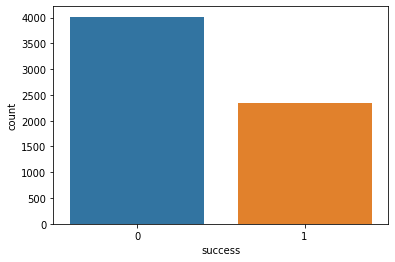

In [ ]:
df['success'].value_counts()
sns.countplot(df['success'])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


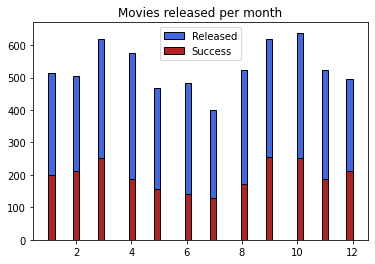

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


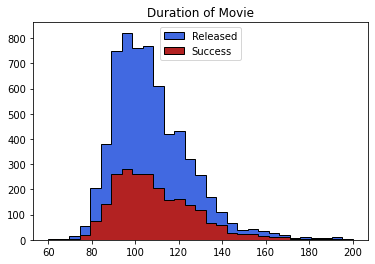

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


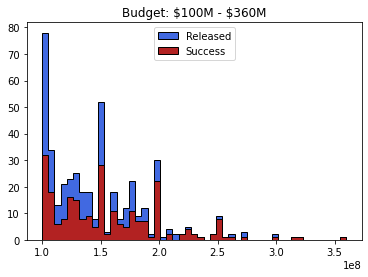

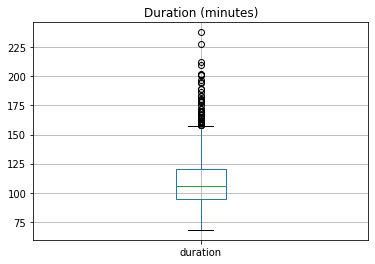

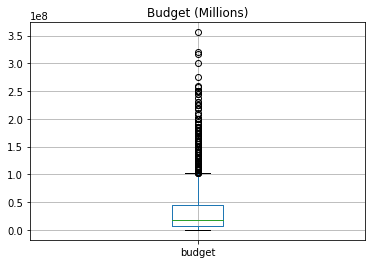

In [ ]:
x = df['month']
y = df[df['success'] == 1]['month']
bins = np.linspace(1, 12)
plt.hist([y, x], bins, label=['Success', 'Released'], histtype='stepfilled', color=['firebrick','royalblue'], edgecolor='k')
plt.legend(loc='upper center')
plt.title("Movies released per month")
plt.show()

x = df['duration']
y = df[df['success'] == 1]['duration']
bins = np.linspace(60, 200, 30)
plt.hist([y, x], bins, label=['Success', 'Released'], histtype='stepfilled', color=['firebrick','royalblue'], edgecolor='k')
plt.legend(loc='upper center')
plt.title("Duration of Movie")
plt.show()

x = df['budget']
y = df[df['success'] == 1]['budget']
bins = np.linspace(100000000, 360000000, 50)
plt.hist([y, x], bins, label=['Success', 'Released'], histtype='stepfilled', color=['firebrick','royalblue'], edgecolor='k')
plt.legend(loc='upper center')
plt.title("Budget: \$100M - \$360M")
plt.show()

plt.title("Duration (minutes)")
boxplot = df.where(df["success"] == 1).boxplot(column=['duration'])
plt.show()

plt.title("Budget (Millions)")
boxplot = df.where(df["success"] == 1).boxplot(column=['budget'])
plt.show()

['duration', 'budget', 'month', 'success']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


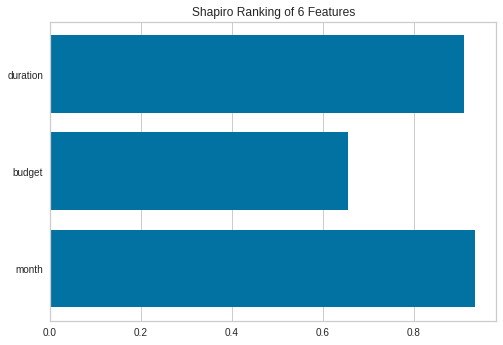

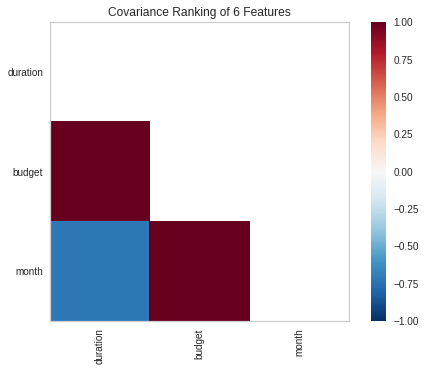

In [ ]:
# Drop all Object columns
df = df.select_dtypes(exclude=['object'])
X, y = df.iloc[:, 0:-1].values, df.iloc[:, -1].values

print(list(df))

feature_names = ['duration', 'budget', 'month']
target_name = 'success'


# https://heartbeat.fritz.ai/analyzing-machine-learning-models-with-yellowbrick-37795733f3ee
from yellowbrick.features import Rank1D
visualizer = Rank1D(features=feature_names, algorithm='shapiro')
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.poof()


from yellowbrick.features import Rank2D
visualizer = Rank2D(features=feature_names, algorithm='covariance') 
#visualizer = Rank2D(features=feature_names, algorithm='pearson')
visualizer.fit(X, y)                
visualizer.transform(X)             
visualizer.poof()


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


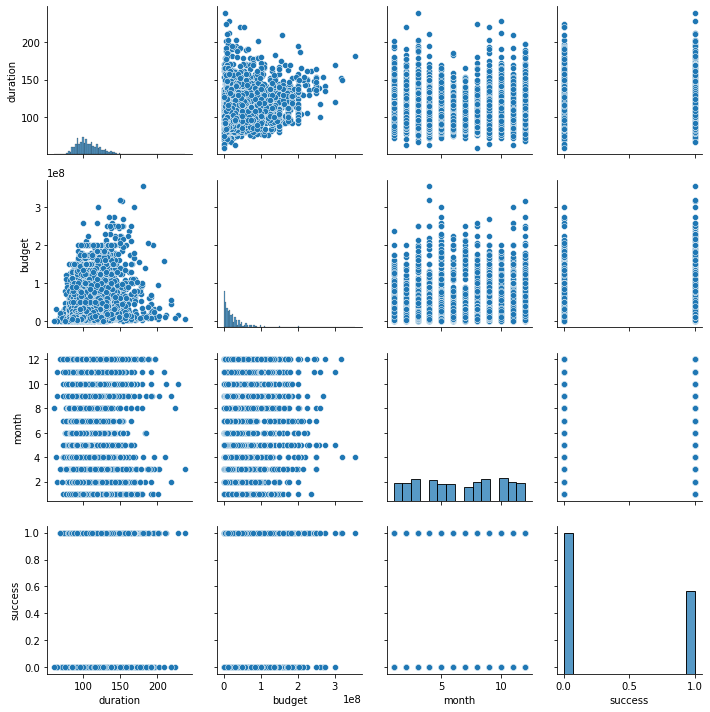

In [ ]:
cols = ['duration', 'budget', 'month', 'success']
sns.pairplot(df[cols], size=2.5)
plt.tight_layout()
plt.show()

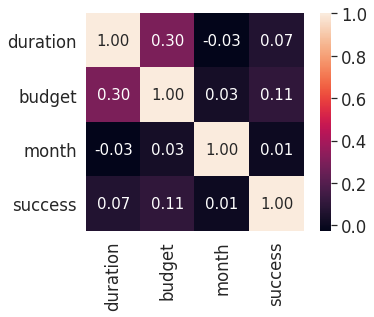

In [ ]:
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
  cbar=True,
  annot=True,
  square=True,
  fmt='.2f',
  annot_kws={'size': 15},
  yticklabels=cols,
  xticklabels=cols)

plt.show()

IndexError: ignored

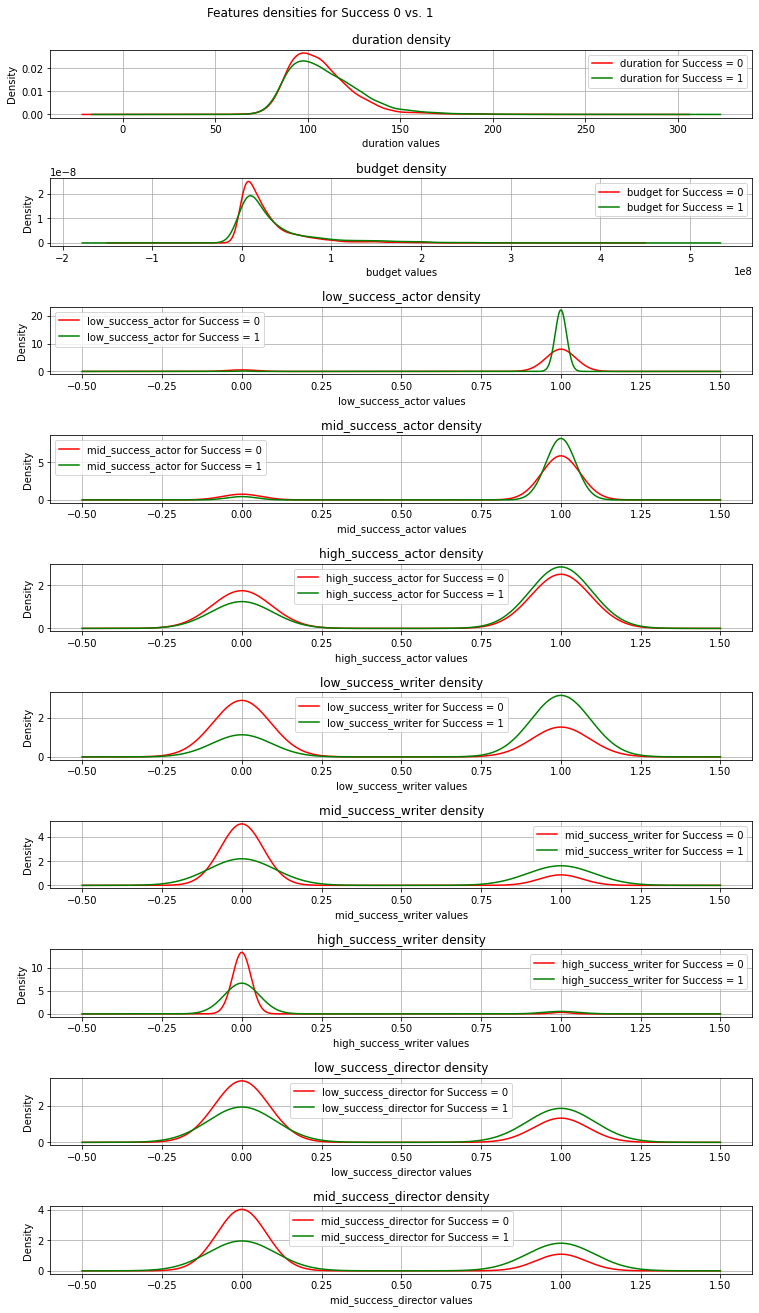

In [ ]:
# We can verify these results using the density plots for each feature with relevance to the outcome. This is not that complex since we only have two outcomes: 0 or 1. So it would look like this in code
# In the plots, when the green and red curves are almost the same (overlapping), it means the feature does not separate the outcomes.
# When you can see some separation this is in agreement with the correlation values.

import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt


def plot_densities(data):
    '''
    Plot features densities depending on the outcome values
    '''
    # change fig size to fit all subplots beautifully 
    rcParams['figure.figsize'] = 15, 20

    # separate data based on outcome values 
    outcome_0 = data[data['success'] == 0]
    outcome_1 = data[data['success'] == 1]

    # init figure
    fig, axs = plt.subplots(10, 1)
    fig.suptitle('Features densities for Success 0 vs. 1')
    plt.subplots_adjust(left = 0.25, right = 0.9, bottom = 0.1, top = 0.95,
                        wspace = 0.2, hspace = 0.9)

    # plot densities for outcomes
    for column_name in names[:-1]: 
        ax = axs[names.index(column_name)]
        #plt.subplot(4, 2, names.index(column_name) + 1)
        outcome_0[column_name].plot(kind='density', ax=ax, subplots=True, 
                                    sharex=False, color="red", legend=True,
                                    label=column_name + ' for Success = 0')
        outcome_1[column_name].plot(kind='density', ax=ax, subplots=True, 
                                     sharex=False, color="green", legend=True,
                                     label=column_name + ' for Success = 1')
        ax.set_xlabel(column_name + ' values')
        ax.set_title(column_name + ' density')
        ax.grid('on')
    plt.show()
    fig.savefig('densities.png')

# load your data 
data  = df
names = list(data.columns)

# plot correlation & densities
plot_densities(data)

# Creating dummy variables for Genre and Month

In [ ]:
# Converting pandas column of comma-separated strings into dummy variables - 21 columns
# Remove spaces b/c after converting, genre_ Action and genre_Action were entered as 2 different columns

df['genre'] = df['genre'].str.replace(' ', '')
df = pd.concat([df, df['genre'].str.get_dummies(sep=',').add_prefix('genre_')], axis = 1)

# Even though Months are numbers, it is categorical so convert it to dummies
df_months = pd.get_dummies(df['month'], prefix='month')
df = pd.concat([df, df_months], axis=1)

# Move Success back to the end
df = df[[c for c in df if c not in ['success']] + ['success']]

# Drop columns I no longer need 
df.drop(['genre','month'], axis=1, inplace=True)

# Looking at the cleaned data set

In [ ]:
df.head()
df.shape
df.info()
df.describe().T
print(list(df))

#df.to_csv(r'/content/sample_data/IMDB_movies_cleaned.csv', index = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6368 entries, 0 to 6367
Data columns (total 45 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   duration               6368 non-null   int64
 1   budget                 6368 non-null   int64
 2   low_success_actor      6368 non-null   int64
 3   mid_success_actor      6368 non-null   int64
 4   high_success_actor     6368 non-null   int64
 5   low_success_writer     6368 non-null   int64
 6   mid_success_writer     6368 non-null   int64
 7   high_success_writer    6368 non-null   int64
 8   low_success_director   6368 non-null   int64
 9   mid_success_director   6368 non-null   int64
 10  high_success_director  6368 non-null   int64
 11  genre_Action           6368 non-null   int64
 12  genre_Adventure        6368 non-null   int64
 13  genre_Animation        6368 non-null   int64
 14  genre_Biography        6368 non-null   int64
 15  genre_Comedy           6368 non-null  

# Building, Training, and Testing the models

## PCA

(6368, 44) (6368,) (4457, 44) (4457,) (1911, 44) (1911,)
 1) budget                         0.135576
 2) low_success_writer             0.129398
 3) duration                       0.118364
 4) mid_success_writer             0.083165
 5) mid_success_director           0.069679
 6) low_success_director           0.063833
 7) high_success_actor             0.020460
 8) genre_Drama                    0.020420
 9) high_success_writer            0.019117
10) genre_Comedy                   0.018454
11) genre_Crime                    0.016026
12) genre_Action                   0.015921
13) genre_Adventure                0.014802
14) genre_Romance                  0.014768
15) genre_Thriller                 0.013397
16) month_10                       0.012591
17) high_success_director          0.012497
18) month_9                        0.012263
19) month_3                        0.011708
20) genre_Mystery                  0.011503
21) month_11                       0.011396
22) month_4        

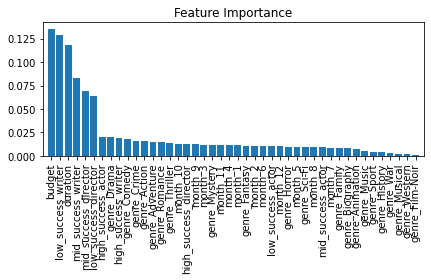

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

# Now split into Training and Test data
X = df.iloc[:, 0:-1]
y = df['success']

X_train, X_test, y_train, y_test = train_test_split(
       X, y, test_size=0.3, random_state=1)

print(X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Scale the data
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

feat_labels = df.columns[0:-1]

forest = RandomForestClassifier(random_state=1)
forest.fit(X_train_std, y_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train_std.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train_std.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train_std.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train_std.shape[1]])
plt.tight_layout()
plt.show()

In [ ]:
# Get a basis to determine if I should use PCA (use StandardScaler and LogisticRegression)

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=1))

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('Test Accuracy: %.3f' % pipe.score(X_test, y_test))

scores = cross_val_score(estimator=pipe,
                             X=X_train,
                             y=y_train,
                             cv=5,
                             n_jobs=1)

print('CV accuracy scores: {}'.format(scores))
print('CV accuracy mean:{} and std:{}'.format(np.mean(scores), np.std(scores)))

Test Accuracy: 0.779
CV accuracy scores: [0.7970852  0.77578475 0.79012346 0.79573513 0.79124579]
CV accuracy mean:0.7899948664522655 and std:0.007572742336491813


In [ ]:
# Now see if PCA improved or compromised my model?

from sklearn.decomposition import PCA

# Now add PCA into my pipeline
pipe = make_pipeline(StandardScaler(),
                     PCA(n_components=2),
                     LogisticRegression(random_state=1))

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('Test Accuracy: %.3f' % pipe.score(X_test, y_test))

scores = cross_val_score(estimator=pipe,
                             X=X_train,
                             y=y_train,
                             cv=5,
                             n_jobs=1)

print('CV accuracy scores: {}'.format(scores))
print('CV accuracy mean:{} and std:{}'.format(np.mean(scores), np.std(scores)))

Test Accuracy: 0.637
CV accuracy scores: [0.65919283 0.63004484 0.65768799 0.671156   0.66105499]
CV accuracy mean:0.655827331612085 and std:0.013724590971716088


## Comparing different Transformers

In [ ]:
# Use different Transformers
from sklearn import preprocessing
import json

output = []

def process_model(name, input_model):
  if (name == "[None]"):
    pipe = make_pipeline(LogisticRegression(max_iter=1000, random_state=1))
  else:
    pipe = make_pipeline(input_model, LogisticRegression(max_iter=1000, random_state=1))
  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_test)
  test_Accuracy = pipe.score(X_test, y_test)
  return {"name": name, "accuracy": round(test_Accuracy, 3)}

output.append(process_model("[None]", ""))
output.append(process_model("StandardScaler", preprocessing.StandardScaler()))
output.append(process_model("MinMaxScaler", preprocessing.MinMaxScaler()))
output.append(process_model("RobustScaler", preprocessing.RobustScaler()))
output.append(process_model("PowerTransformer", preprocessing.PowerTransformer()))
output.append(process_model("FunctionTransformer", preprocessing.FunctionTransformer()))
output.append(process_model("MaxAbsScaler", preprocessing.MaxAbsScaler()))
output.append(process_model("Normalizer", preprocessing.Normalizer()))
output.append(process_model("Binarizer", preprocessing.Binarizer()))
output.append(process_model("PolynomialFeatures", preprocessing.PolynomialFeatures()))
output.append(process_model("QuantileTransformer", preprocessing.QuantileTransformer()))

print(json.dumps(output, indent=4))


import csv
csv_columns = ['name', 'accuracy']

csv_file = "Transformers.csv"
try:
    with open(csv_file, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        for data in output:
            writer.writerow(data)
except IOError:
    print("I/O error")


[
    {
        "name": "[None]",
        "accuracy": 0.614
    },
    {
        "name": "StandardScaler",
        "accuracy": 0.779
    },
    {
        "name": "MinMaxScaler",
        "accuracy": 0.774
    },
    {
        "name": "RobustScaler",
        "accuracy": 0.78
    },
    {
        "name": "PowerTransformer",
        "accuracy": 0.802
    },
    {
        "name": "FunctionTransformer",
        "accuracy": 0.614
    },
    {
        "name": "MaxAbsScaler",
        "accuracy": 0.776
    },
    {
        "name": "Normalizer",
        "accuracy": 0.614
    },
    {
        "name": "Binarizer",
        "accuracy": 0.769
    },
    {
        "name": "PolynomialFeatures",
        "accuracy": 0.386
    },
    {
        "name": "QuantileTransformer",
        "accuracy": 0.804
    }
]


## Comparing different Classifiers

In [ ]:
# Use different Linear Models
from sklearn.preprocessing import QuantileTransformer
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn import svm
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import accuracy_score
import json

output = []

def process_model(name, input_model):
  pipe = make_pipeline(QuantileTransformer(random_state=1), input_model)
  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_test)
  test_Accuracy = pipe.score(X_test, y_test)
  return {"name": name, "accuracy": round(test_Accuracy, 3)}

output.append(process_model("Perceptron", linear_model.Perceptron(tol=1e-3, random_state=1)))
output.append(process_model("LogisticRegression", linear_model.LogisticRegression(max_iter=1000, random_state=1)))
output.append(process_model("LogisticRegressionCV", linear_model.LogisticRegressionCV(cv=5, max_iter=1000, random_state=1)))
output.append(process_model("RidgeClassifier", linear_model.RidgeClassifier(random_state=1)))
output.append(process_model("RidgeClassifierCV", linear_model.RidgeClassifierCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1])))
output.append(process_model("SGDClassifier", linear_model.SGDClassifier(max_iter=1000, tol=1e-3, random_state=1)))
output.append(process_model("LinearRegression", linear_model.LinearRegression()))
output.append(process_model("BayesianRidge", linear_model.BayesianRidge()))

output.append(process_model("BernoulliNB", naive_bayes.BernoulliNB()))
output.append(process_model("CategoricalNB", naive_bayes.CategoricalNB()))
output.append(process_model("ComplementNB", naive_bayes.ComplementNB()))
output.append(process_model("GaussianNB", naive_bayes.GaussianNB()))
output.append(process_model("MultinomialNB", naive_bayes.MultinomialNB()))

output.append(process_model("KNeighborsClassifier(3)", neighbors.KNeighborsClassifier(n_neighbors=3)))
output.append(process_model("KNeighborsClassifier(5)", neighbors.KNeighborsClassifier(n_neighbors=5)))
output.append(process_model("KNeighborsRegressor(3)", neighbors.KNeighborsRegressor(n_neighbors=3)))
output.append(process_model("KNeighborsRegressor(5)", neighbors.KNeighborsRegressor(n_neighbors=5)))
output.append(process_model("RadiusNeighborsClassifier", neighbors.RadiusNeighborsClassifier(radius=10.0)))
output.append(process_model("NearestCentroid", neighbors.NearestCentroid()))

output.append(process_model("SVC", svm.SVC(gamma='auto')))
output.append(process_model("LinearSVC", svm.LinearSVC(random_state=0, tol=1e-5)))
output.append(process_model("NuSVC", svm.NuSVC()))

output.append(process_model("DecisionTreeClassifier", tree.DecisionTreeClassifier()))
output.append(process_model("DecisionTreeRegressor", tree.DecisionTreeRegressor()))
output.append(process_model("ExtraTreeClassifier", tree.ExtraTreeClassifier()))

output.append(process_model("AdaBoostClassifier", ensemble.AdaBoostClassifier(n_estimators=100, random_state=1)))
output.append(process_model("BaggingClassifier-SVC", ensemble.BaggingClassifier(base_estimator=svm.SVC(), n_estimators=10, random_state=0)))
output.append(process_model("BaggingClassifier-NuSVC", ensemble.BaggingClassifier(base_estimator=svm.NuSVC(), n_estimators=10, random_state=0)))
output.append(process_model("ExtraTreesClassifier", ensemble.ExtraTreesClassifier(n_estimators=100, random_state=0)))
output.append(process_model("GradientBoostingClassifier", ensemble.GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)))
output.append(process_model("RandomForestClassifier", ensemble.RandomForestClassifier(max_depth=10, random_state=1)))

print(json.dumps(output, indent=4))

import csv
csv_columns = ['name', 'accuracy']

csv_file = "Classifiers.csv"
try:
    with open(csv_file, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        for data in output:
            writer.writerow(data)
except IOError:
    print("I/O error")

[
    {
        "name": "Perceptron",
        "accuracy": 0.744
    },
    {
        "name": "LogisticRegression",
        "accuracy": 0.804
    },
    {
        "name": "LogisticRegressionCV",
        "accuracy": 0.806
    },
    {
        "name": "RidgeClassifier",
        "accuracy": 0.802
    },
    {
        "name": "RidgeClassifierCV",
        "accuracy": 0.802
    },
    {
        "name": "SGDClassifier",
        "accuracy": 0.72
    },
    {
        "name": "LinearRegression",
        "accuracy": 0.413
    },
    {
        "name": "BayesianRidge",
        "accuracy": 0.412
    },
    {
        "name": "BernoulliNB",
        "accuracy": 0.729
    },
    {
        "name": "CategoricalNB",
        "accuracy": 0.729
    },
    {
        "name": "ComplementNB",
        "accuracy": 0.708
    },
    {
        "name": "GaussianNB",
        "accuracy": 0.627
    },
    {
        "name": "MultinomialNB",
        "accuracy": 0.713
    },
    {
        "name": "KNeighborsClassifier(3)",
  

In [ ]:
# Neural Network
from sklearn import neural_network
from sklearn.model_selection import cross_val_score

nn = neural_network.MLPClassifier(hidden_layer_sizes=(10,10,10),max_iter=1000)
#nn = neural_network.MLPClassifier(hidden_layer_sizes=(20,20,20),max_iter=1000)
#nn = neural_network.MLPRegressor(hidden_layer_sizes=(10,10,10),max_iter=1000)

#nn = make_pipeline(QuantileTransformer(random_state=1), neural_network.MLPClassifier(hidden_layer_sizes=(10,10,10),max_iter=1000))
##nn = make_pipeline(QuantileTransformer(random_state=1), neural_network.MLPRegressor(hidden_layer_sizes=(20,20,20),max_iter=1000))

nn.fit(X_train, y_train)
y_pred = nn.predict(X_test)

print('Test Accuracy: %.3f' % nn.score(X_test, y_test))
scores = cross_val_score(estimator=nn,
                             X=X_train,
                             y=y_train,
                             cv=5,
                             n_jobs=1)

print('CV accuracy scores: {}'.format(scores))
print('CV accuracy mean:{} and std:{}'.format(np.mean(scores), np.std(scores)))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Test Accuracy: 0.391


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


CV accuracy scores: [0.40358744 0.367713   0.3714927  0.64197531 0.52300786]
CV accuracy mean:0.4615552636479393 and std:0.10640086090989144


In [ ]:
# Does Transformer help?  Yes
from sklearn.ensemble import BaggingClassifier
#pipe = make_pipeline(BaggingClassifier(base_estimator=svm.NuSVC(), n_estimators=10, random_state=0))
pipe = make_pipeline(QuantileTransformer(random_state=1), BaggingClassifier(base_estimator=svm.SVC(random_state=1), n_estimators=10, random_state=0))

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('Test Accuracy: %.3f' % pipe.score(X_test, y_test))

scores = cross_val_score(estimator=pipe,
                             X=X_train,
                             y=y_train,
                             cv=5,
                             n_jobs=1)

print('CV accuracy scores: {}'.format(scores))
print('CV accuracy mean:{} and std:{}'.format(np.mean(scores), np.std(scores)))

Test Accuracy: 0.811
CV accuracy scores: [0.82623318 0.79484305 0.80808081 0.80359147 0.81481481]
CV accuracy mean:0.8095126652675232 and std:0.010582976224868168


## Using GridSearchCV to tweak hyperparameters on model with best Transformer/Classifier

In [ ]:
# Gridsearch CV on BaggingClassifier with QuantileTransformer

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

param_grid = {
    'baggingclassifier__base_estimator__C': [0.1, 1, 10, 100, 1000], 
    'baggingclassifier__base_estimator__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'baggingclassifier__base_estimator__kernel': ['rbf'],
    'quantiletransformer__n_quantiles': [100, 1000, 3565],
    'quantiletransformer__output_distribution': ['uniform','normal']
} 

gs = GridSearchCV(make_pipeline(QuantileTransformer(random_state=1),
                                BaggingClassifier(base_estimator=svm.SVC(random_state=1), n_estimators=10, random_state=1)),
                  param_grid=param_grid, cv= 5, verbose=True)

# for param in gs.get_params().keys():
#     print(param)

gs = gs.fit(X_train, y_train)

print(gs.best_score_)

# print best parameter after tuning
print(gs.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(gs.best_estimator_)


Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed: 77.1min finished


0.8162466720015299
{'baggingclassifier__base_estimator__C': 1000, 'baggingclassifier__base_estimator__gamma': 0.001, 'baggingclassifier__base_estimator__kernel': 'rbf', 'quantiletransformer__n_quantiles': 100, 'quantiletransformer__output_distribution': 'uniform'}
Pipeline(memory=None,
         steps=[('quantiletransformer',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=100,
                                     output_distribution='uniform',
                                     random_state=1, subsample=100000)),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=SVC(C=1000, break_ties=False,
                                                      cache_size=200,
                                                      class_weight=None,
                                                      coef0=0.0,
                                                      decision_function_sha

# Using tuned hyperparameters, generate ROC-AOC curve and Confusion Matrix

roc_auc_score for BaggingClassifier w. SVC:  0.8607189311449807


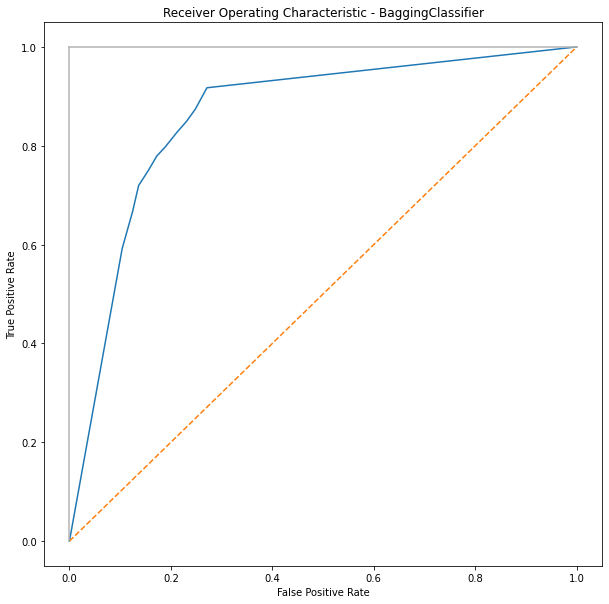

In [3]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.svm import SVC

optimized_rfc = make_pipeline(QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                            n_quantiles=100,
                            output_distribution='uniform',
                            random_state=1, subsample=100000),
                        BaggingClassifier(base_estimator=SVC(C=1000, break_ties=False,
                            cache_size=200,
                            class_weight=None,
                            coef0=0.0,
                            decision_function_shape='ovr',
                            degree=3, gamma=0.001,
                            kernel='rbf', max_iter=-1,
                            probability=False,
                            random_state=1,
                            shrinking=True, tol=0.001,
                            verbose=False),
                            bootstrap=True, bootstrap_features=False,
                            max_features=1.0, max_samples=1.0,
                            n_estimators=10, n_jobs=None,
                            oob_score=False, random_state=1, verbose=0,
                            warm_start=False))

optimized_rfc.fit(X_train, y_train);
y_score = optimized_rfc.predict_proba(X_test)[:,1]

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score)
print('roc_auc_score for BaggingClassifier w. SVC: ', roc_auc_score(y_test, y_score))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - BaggingClassifier')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

pipe = make_pipeline(QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                            n_quantiles=100,
                            output_distribution='uniform',
                            random_state=1, subsample=100000),
                        BaggingClassifier(base_estimator=SVC(C=1000, break_ties=False,
                            cache_size=200,
                            class_weight=None,
                            coef0=0.0,
                            decision_function_shape='ovr',
                            degree=3, gamma=0.001,
                            kernel='rbf', max_iter=-1,
                            probability=False,
                            random_state=1,
                            shrinking=True, tol=0.001,
                            verbose=False),
                            bootstrap=True, bootstrap_features=False,
                            max_features=1.0, max_samples=1.0,
                            n_estimators=10, n_jobs=None,
                            oob_score=False, random_state=1, verbose=0,
                            warm_start=False))

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Test Accuracy: %.3f' % pipe.score(X_test, y_test))
scores = cross_val_score(estimator=pipe,
                             X=X_train,
                             y=y_train,
                             cv=5,
                             n_jobs=1)

print('CV accuracy scores: {}'.format(scores))
print('CV accuracy mean:{} and std:{}'.format(np.mean(scores), np.std(scores)))


Test Accuracy: 0.809
CV accuracy scores: [0.80829596 0.81278027 0.81818182 0.81257015 0.82940516]
CV accuracy mean:0.8162466720015299 and std:0.00728885750248172


[[971 202]
 [163 575]]
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1173
           1       0.74      0.78      0.76       738

    accuracy                           0.81      1911
   macro avg       0.80      0.80      0.80      1911
weighted avg       0.81      0.81      0.81      1911



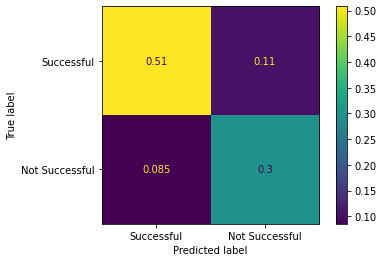

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

optimized_rfc.fit(X_train, y_train)
pred_optimized_rfc = optimized_rfc.predict(X_test)
print(confusion_matrix(y_test, pred_optimized_rfc))
print(classification_report(y_test, pred_optimized_rfc))

cm = confusion_matrix(y_test, pred_optimized_rfc, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['Successful','Not Successful'])
cmd.plot()

# What is the prediction of a potential new movie?

What is the prediction for my mid-summer, $35 Million, 2 hour action/musical, starring low and moderately successful actors/actresses, written by a first-time writer, and directed by a highly successful director?

In [30]:
new_movie = {
    'duration' : 120, 
    'budget' : 35000000, 
    'low_success_actor' : 1, 
    'mid_success_actor' : 1, 
    'high_success_actor' : 0, 
    'low_success_writer' : 1, 
    'mid_success_writer' : 0, 
    'high_success_writer' : 0, 
    'low_success_director' : 0, 
    'mid_success_director' : 0, 
    'high_success_director' : 1, 
    'genre_Action' : 1, 
    'genre_Adventure' : 0, 
    'genre_Animation' : 0, 
    'genre_Biography' : 0, 
    'genre_Comedy' : 0, 
    'genre_Crime' : 0, 
    'genre_Drama' : 0, 
    'genre_Family' : 0, 
    'genre_Fantasy' : 0, 
    'genre_Film-Noir' : 0, 
    'genre_History' : 0, 
    'genre_Horror' : 0, 
    'genre_Music' : 0, 
    'genre_Musical' : 1, 
    'genre_Mystery' : 0, 
    'genre_Romance' : 0, 
    'genre_Sci-Fi' : 0, 
    'genre_Sport' : 0, 
    'genre_Thriller' : 0, 
    'genre_War' : 0, 
    'genre_Western' : 0, 
    'month_1' : 0, 
    'month_2' : 0, 
    'month_3' : 0, 
    'month_4' : 0, 
    'month_5' : 0, 
    'month_6' : 0, 
    'month_7' : 1, 
    'month_8' : 0, 
    'month_9' : 0, 
    'month_10' : 0, 
    'month_11' : 0, 
    'month_12' : 0}

df_new_movie = pd.DataFrame(new_movie, index=[0])

pred_new_movie = pipe.predict(df_new_movie)
if pred_new_movie[0] == 0:
  print("Movie will not be a success")
else:
  print("Movie will be a success")

Movie will not be a success
